In [41]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import bz2
import json
import os
from tqdm import tqdm

# Utility function and paths variables

In [48]:
def apply_to_stream(f, input_file, chunksize=750000):
    with pd.read_json(input_file, lines=True, compression='bz2', chunksize=chunksize) as df_reader:
        for chunk in tqdm(df_reader):
            f(chunk)


def apply_to_stream_and_save(f, input_file, output_file, chunksize=750000):
    with pd.read_json(input_file, lines=True, compression='bz2', chunksize=chunksize) as df_reader:
        with bz2.open(output_file, 'wb') as out_file:
            for df_chunk in tqdm(df_reader):
                write_df_chunk_to_file(f(df_chunk), out_file)


def apply_to_all_files_stream_and_save(f, all_files, output_file, chunksize=750000):
    # Open only once the output file, so just append all the content to it
    with bz2.open(output_file, 'wb') as out_file:
        for input_file in all_files:
            with pd.read_json(input_file, lines=True, compression='bz2', chunksize=chunksize) as df_reader:
                    for df_chunk in tqdm(df_reader):
                        write_df_chunk_to_file(f(df_chunk), out_file)
                        
            print(f'==> File "{input_file}" processed')


def write_df_chunk_to_file(df_chunk, out_file):
    out_file.write(df_chunk.to_json(orient='records', lines=True).encode('utf-8'))

In [3]:
data_folder = 'data/'
quotes_2015 = data_folder + 'quotes-2015.json.bz2'
quotes_2016 = data_folder + 'quotes-2016.json.bz2'
quotes_2017 = data_folder + 'quotes-2017.json.bz2'
quotes_2018 = data_folder + 'quotes-2018.json.bz2'
quotes_2019 = data_folder + 'quotes-2019.json.bz2'
quotes_2020 = data_folder + 'quotes-2020.json.bz2'
all_files = [quotes_2015, quotes_2016, quotes_2017, quotes_2018, quotes_2019, quotes_2020]

wikidata_parquet = data_folder + 'speaker_attributes.parquet'

# Formats of the differents features

In [4]:
def get(nb):
    with pd.read_json(quotes_2015, lines=True, compression='bz2', chunksize=nb) as df_reader:
        for chunk in df_reader:
            return chunk

In [5]:
first_chunk = get(50)

In [6]:
first_chunk.head(50)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2015-08-31-000271,... a great day for veterans here in Littleton...,Jeanne Shaheen,[Q270316],2015-08-31 02:10:00,2,"[[Jeanne Shaheen, 0.742], [None, 0.2359], [Kel...",[http://www.unionleader.com/article/20150831/N...,E
1,2015-12-08-029916,How FFA scored 32 own goals in 18 months and C...,None,[],2015-12-08 00:00:00,2,"[[None, 0.563], [David Gallop, 0.437]]",[http://feeds.theroar.com.au/~r/theroar/~3/tZ3...,E
2,2015-09-10-000206,[ Amy ] was placed under an unacceptable amoun...,None,[],2015-09-10 21:18:59,1,"[[None, 0.9634], [Amy Robinson, 0.0366]]",[http://www.thefashionspot.com/buzz-news/lates...,E
3,2015-07-23-032707,How High Will These Numbers Go?,None,[],2015-07-23 14:57:49,3,"[[None, 0.9019], [Chubby Checker, 0.0981]]","[http://www.billboard.com/node/6641719, http:/...",E
4,2015-10-04-000115,[ Ban ] recalls that hospitals and medical per...,Ban Ki-moon,[Q1253],2015-10-04 08:27:38,2,"[[Ban Ki-moon, 0.8399], [None, 0.1601]]",[http://muslimnews.co.uk/news/middle-east/afgh...,E
5,2015-06-19-016191,How Indian values and karma can help business ...,Sri Sri Ravi Shankar,[Q468374],2015-06-19 15:32:16,1,"[[Sri Sri Ravi Shankar, 0.4169], [None, 0.2844...",[http://newkerala.com/news/2015/fullnews-74877...,E
6,2015-08-31-000309,[ But ] We were able to network within our com...,Jamal Rifi,[Q19874690],2015-08-31 22:59:36,1,"[[Jamal Rifi, 0.6109], [None, 0.3891]]",[http://sbs.com.au/content/muslim-leader-named...,E
7,2015-09-21-030618,How it worked is that they had a keyboard and ...,Richard Burmeister,[Q18601741],2015-09-21 19:00:00,1,"[[Richard Burmeister, 0.875], [None, 0.125]]",[http://sarahrosedevilliers.wordpress.com/2015...,E
8,2015-12-10-000332,[ C ] harter operators working through third-p...,Diane Ravitch,[Q5271548],2015-12-10 17:51:45,1,"[[Diane Ravitch, 0.8078], [None, 0.1922]]",[http://enewspf.com/2015/12/10/report-shows-ho...,E
9,2015-06-18-018819,How long do you think it'll take for Donald Tr...,Chris Matthews,"[Q15735939, Q25189328, Q5107375, Q5110828, Q51...",2015-06-18 10:00:00,1,"[[Chris Matthews, 0.3869], [None, 0.3198], [Do...",[http://talkingpointsmemo.com/dc/donald-trump-...,E


In [7]:
first_chunk.iloc[1]['speaker'] == 'None'

True

We will replace these string 'None' by proper Nan to ease the processing with pandas.

In [8]:
first_chunk['quoteID'].describe()

count                    50
unique                   50
top       2015-08-31-000271
freq                      1
Name: quoteID, dtype: object

In [9]:
first_chunk['quotation'].describe()

count                                                    50
unique                                                   50
top       ... a great day for veterans here in Littleton...
freq                                                      1
Name: quotation, dtype: object

In [10]:
first_chunk['speaker'].describe()

count       50
unique      38
top       None
freq        13
Name: speaker, dtype: object

In [11]:
first_chunk['qids'].describe()

count     50
unique    38
top       []
freq      13
Name: qids, dtype: object

In [12]:
first_chunk['date'].describe()

/tmp/ipykernel_11494/2974118476.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  first_chunk['date'].describe()


count                      50
unique                     50
top       2015-08-31 02:10:00
freq                        1
first     2015-03-08 06:11:56
last      2015-12-31 17:05:06
Name: date, dtype: object

We will need to transform the date column type to a proper datetime type.

In [13]:
first_chunk['numOccurrences'].describe()

count    50.000000
mean      2.200000
std       4.961073
min       1.000000
25%       1.000000
50%       1.000000
75%       1.750000
max      35.000000
Name: numOccurrences, dtype: float64

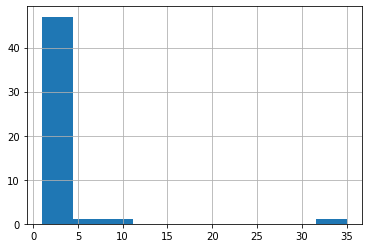

In [14]:
first_chunk['numOccurrences'].hist()
plt.show()

In [15]:
first_chunk['probas'].describe()

count                                                    50
unique                                                   50
top       [[Jeanne Shaheen, 0.742], [None, 0.2359], [Kel...
freq                                                      1
Name: probas, dtype: object

The probas feature already contains python list.

In [16]:
first_chunk['urls'].describe()

count                                                    50
unique                                                   50
top       [http://www.unionleader.com/article/20150831/N...
freq                                                      1
Name: urls, dtype: object

In [17]:
first_chunk['phase'].describe()

count     50
unique     1
top        E
freq      50
Name: phase, dtype: object

It seems that the column 'phase' does contain much information since it is always the same value (to be confirmed on the entire dataset). If it is the case, we can just drop it.

#### Total number of records

In [17]:
count = 0

for input_file in all_files:
    with pd.read_json(input_file, lines=True, compression='bz2', chunksize=100000) as df_reader:
        for chunk in df_reader:
            count += chunk.shape[0]
    print(f'==> File "{input_file}" finished')

print(f'Total number of records : {count}')

==> File "data/quotes-2015.json.bz2" finished
==> File "data/quotes-2016.json.bz2" finished
==> File "data/quotes-2017.json.bz2" finished
==> File "data/quotes-2018.json.bz2" finished
==> File "data/quotes-2019.json.bz2" finished
==> File "data/quotes-2020.json.bz2" finished
Total number of records : 115584257


Total number of records : 115584257

# Merge of the files of all years
To facilitate the streaming processing of the data, we will merge the 6 files into a single one. When doing so, we will also change the type of the date column to datetime.

In [34]:
def cast_date_remove_authors_low_proba(df_chunk):
    def create_col_author_highest_proba(row):
        max_proba = -1.0
        max_author = None
        
        for author, proba in row['probas']:
            if float(proba) > max_proba:
                max_proba = float(proba)
                max_author = author
                
        return max_author, max_proba
        
        
    # Cast the date column to datetime
    df_chunk['date'] = pd.to_datetime(df_chunk['date'])
    
    # Cast the string 'None' for the speaker column to proper np.nan
    df_chunk['speaker'] = df_chunk['speaker'].replace('None', np.nan)
    
    # Drop all the rows where the author is nan
    df_chunk.dropna(subset=['speaker'], inplace=True)
    
    # Create 2 new columns with author, proba that has the highest proba
    df_chunk[['author_highest_proba', 'highest_proba']] = df_chunk.apply(create_col_author_highest_proba, axis=1, result_type='expand')
    
    # Check if for some rows the author is not the author with the highest proba
    if not df_chunk['speaker'].equals(df_chunk['author_highest_proba']):
        print('========================================================================')
        print('The column "speaker" is not equal to the column "author_highest_proba" !')
        print('========================================================================')
        
        # Print where the 2 columns are different
        print(df_chunk[np.argwhere(not df_chunk['speaker'].equals(df_chunk['author_highest_proba']))])
        
    # Drop the rows where the highest proba is < 0.5
    df_chunk = df_chunk[df_chunk['highest_proba'] >= 0.5]
    
    return df_chunk

In [49]:
%%time

def rename_rec(i):
    try:
        os.rename(output_file, f'data/dataset_old_{i}.json.bz2')
    except OSError:
        rename_rec(i+1)

# Output file
output_file = 'data/dataset.json.bz2'

# Rename old file if it already exists
if os.path.isfile(output_file):
    # File already exists, rename it
    rename_rec(0)

apply_to_all_files_stream_and_save(cast_date_remove_authors_low_proba, all_files, output_file)

28it [1:10:40, 151.45s/it]


==> File "data/quotes-2015.json.bz2" processed


19it [36:17, 114.59s/it]


==> File "data/quotes-2016.json.bz2" processed


36it [1:17:53, 129.81s/it]


==> File "data/quotes-2017.json.bz2" processed


37it [2:03:19, 199.98s/it]


==> File "data/quotes-2018.json.bz2" processed


30it [52:55, 105.86s/it]


==> File "data/quotes-2019.json.bz2" processed


7it [12:03, 103.33s/it]


==> File "data/quotes-2020.json.bz2" processed
CPU times: user 6h 5min 24s, sys: 8min 9s, total: 6h 13min 33s
Wall time: 6h 13min 10s
